# European Futbol Odds Analysis
> Checking out Soccer/Football odds

- toc: false
- badges: true
- comments: true
- categories: [soccer, benchmark, webscraping, brier, accuracy, calibration]

I've started thinking about applying machine learning to betting the European Soccer Leagues. It seems like it's going to be a little bit different of a problem, as there are 3 possible outcomes for every match (win, lose, draw). But still, I'd like to see if the basic process I put together for American Baseball will hold. You can read about it elsewhere on this blog. 

The first step in this process is getting data on how well the oddsmakers can predict the outcomes of these matches. I know that covers.com is pretty easy to scrape data from, and they aggregate the published odds from several sites. So let's see how well they predict match outcomes.

**Each blog post on this site, including this one, is executable. Use the buttons at the top to run the code on Binder of Colab and get fresh results for yourself.** You can also download it from Github to run the notebook locally.

## Scraping Data from Covers.com
> Important: Web scraping is dependant on other people's web pages. If they change their site, this blog's code will break. Don't expect the code presented here to work forever.

Below will download odds data for each of the big 5 European leagues for as long as we have data published on [covers.com](http://covers.com). Almost 2500 matches in all.

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_covers_data(day):
    # day as datetime object
    date = day.strftime("%Y-%m-%d")
    leagues = ['premier-league','la-liga', 'lig1', 'bund','ita']
    data = []
    for league in leagues:
        # prep url and get the page
        url = f'https://www.covers.com/sports/{league}/matchups?selectedDate={date}'
        html = requests.get(url).text
        soup = bs(html,'lxml')

        # check to make sure the date on the page is the same date we want
        page_date = soup.find('a', {"class": 'cmg_active_navigation_item'})['data-date']
        if page_date!=date: return []

        # parse the html
        matchups = soup.findAll('div',{'class':'covers-CoversWorldCup-matchupBlock'})
        for m in matchups:
            d = {}
            try:
                d['league'] = league
                d['date'] = date
                d['home_team_name'] = m.find('div',{'class':'covers-CoversWorldCup-leftFeatureName'}).text.strip()
                d['home_team_odds'] = m.find('div',{'class':'covers-CoversWorldCup-leftFeatureLine'}).text.strip()
                d['draw_odds'] = m.find('div',{'class':'covers-CoversWorldCup-drawOdds'}).text[5:].strip()
                d['away_team_name'] = m.find('div',{'class':'covers-CoversWorldCup-rightFeatureName'}).text.strip()
                d['away_team_odds'] = m.find('div',{'class':'covers-CoversWorldCup-rightFeatureLine'}).text.strip()
                scores = m.find('div',{'class':'covers-CoversWorldCup-timeTag covers-CoversWorldCup-timeTag-inGame'}).findAll('b')
                d['home_team_score'] = scores[0].text
                d['away_team_score'] = scores[1].text
            except:
                pass
            data.append(d)
    return data

In [3]:
game_data = []
# covers.com appears to have scores and odds since beginning of 2018 season
# is appears to have odds (but no scores) for 2016 and 2017 seasons
for i, d in enumerate(pd.date_range('2018-08-10', '2020-12-21')):
    game_data.extend(get_covers_data(d))
    if i%50==0: print(d.date(), len(game_data))

2018-08-10 0
2018-09-29 197
2018-11-18 438
2019-01-07 636
2019-02-26 804
2019-04-17 1052
2019-06-06 1179
2019-07-26 1179
2019-09-14 1289
2019-11-03 1582
2019-12-23 1834
2020-02-11 1834
2020-04-01 1834
2020-05-21 1880
2020-07-10 1880
2020-08-29 1880
2020-10-18 2051
2020-12-07 2306


In [4]:
# format dataframe
df = pd.DataFrame(game_data)
for i in ['home_team_score', 'away_team_score','away_team_odds','home_team_odds','draw_odds']:
    df[i] = pd.to_numeric(df[i], errors='coerce')

In [5]:
df.league.value_counts()

premier-league    505
ita               504
lig1              494
la-liga           482
bund              443
Name: league, dtype: int64

# Accuracy of predictions

In [6]:
# home vs away win percentages
df['result'] = 'Home'
df['result'][df['home_team_score']==df['away_team_score']] = 'Draw'
df['result'][df['home_team_score']<df['away_team_score']] = 'Away'
df.result.value_counts()/len(df)

Home    0.422982
Away    0.317957
Draw    0.259061
Name: result, dtype: float64

So the home team has about a 10% edge over the away team. In fact, if we just be on the home team every game, we would win 42% of the time. Interestingly, 25% of matches end in a draw.

In [7]:
# favorite win %
df['favorite'] = df[['home_team_odds','draw_odds','away_team_odds']].idxmin(axis=1)
df['favorite'] = df['favorite'].str.capitalize().str[:4]
(df['result']==df['favorite']).mean()

0.5049423393739704

If we bet on the casino's odds favorite, we'd win 50% of the time. It's tempting to call it chance, but since we have 3 outcomes chance would be 33%. 

## Save dataframe to file

In [17]:
df.to_csv("covers_data.csv", index=False)
df

,league,date,home_team_name,home_team_odds,draw_odds,away_team_name,away_team_odds,home_team_score,away_team_score,result,favorite
0,premier-league,2018-08-25,WOLVES,1050.0,400.0,MCI,-323.0,1.0,1.0,Draw,Away
1,premier-league,2018-08-25,HUD,140.0,199.0,Cardif,235.0,0.0,0.0,Draw,Home
2,premier-league,2018-08-25,SOUTH,133.0,220.0,LEICTY,225.0,1.0,2.0,Away,Home
3,premier-league,2018-08-25,BOU,160.0,220.0,EVE,175.0,2.0,2.0,Draw,Home
4,premier-league,2018-08-25,ARS,-303.0,400.0,WHU,800.0,3.0,1.0,Home,Home
...,...,...,...,...,...,...,...,...,...,...,...
2423,ita,2020-12-20,SASSU,297.0,300.0,MILAN,-131.0,1.0,2.0,Away,Away
2424,ita,2020-12-20,BEN,-105.0,260.0,GENOA,280.0,2.0,0.0,Home,Home
2425,ita,2020-12-20,CAGLI,242.0,226.0,UDIN,113.0,1.0,1.0,Draw,Away
2426,ita,2020-12-20,ATAL,132.0,224.0,ROMA,198.0,4.0,1.0,Home,Home


# Calibration Levels

Let's look at calibrations levels. This is a measure of whether the probabilities implied by the odds match with the outcomes of the games. If we have a moneyline of 100, then that should happen about 50% of the time. We'll look at it graphically and we'll also measure it using [Brier Score](https://en.wikipedia.org/wiki/Brier_score).

In [13]:
# get probabilities and rate of occurrences for calibrations
prob_df = pd.DataFrame()
prob_df['home_win_prob'] = 100/(df['home_team_odds']+100)
prob_df['home_win_prob'][df['home_team_odds']<0] = -df['home_team_odds']/(-df['home_team_odds']+100)
prob_df['home_win'] = 0
prob_df['home_win'][df['result']=='Home'] = 1

prob_df['away_win_prob'] = 100/(df['away_team_odds']+100)
prob_df['away_win_prob'][df['away_team_odds']<0] = -df['away_team_odds']/(-df['away_team_odds']+100)
prob_df['away_win'] = 0
prob_df['away_win'][df['result']=='Away'] = 1

prob_df['draw_prob'] = 100/(df['draw_odds']+100)
prob_df['draw_prob'][df['draw_odds']<0] = -df['draw_odds']/(-df['draw_odds']+100)
prob_df['draw'] = 0
prob_df['draw'][df['result']=='Draw'] = 1

prob_df = prob_df.dropna()

Home Win	 Brier Loss: 0.2077
Away Win	 Brier Loss: 0.1823
Draw		 Brier Loss: 0.1891


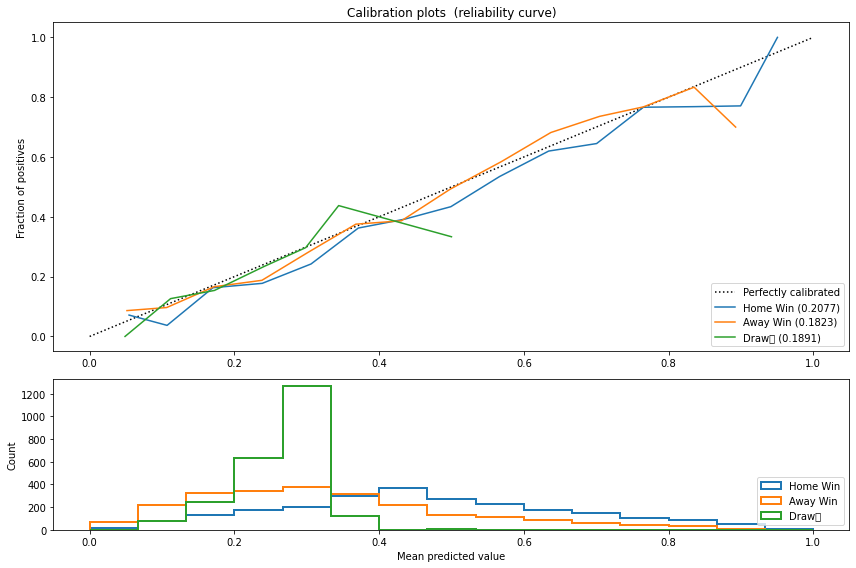

In [16]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

def cal_curve(data, bins):
    # adapted from:
    #https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    fig = plt.figure(1, figsize=(12, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for y_test, y_proba, name in data:
        brier = brier_score_loss(y_test, y_proba)
        print("{}\t Brier Loss: {:.4f}".format(
            name, brier))
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, y_proba, n_bins=bins)
        ax1.plot(mean_predicted_value, fraction_of_positives,
                 label="%s (%1.4f)" % (name, brier))
        ax2.hist(y_proba, range=(0, 1), bins=bins, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

data = [
    (prob_df['home_win'], prob_df['home_win_prob'], 'Home Win'),
    (prob_df['away_win'], prob_df['away_win_prob'], 'Away Win'),
    (prob_df['draw'], prob_df['draw_prob'], 'Draw\t'),
]
cal_curve(data, 15)

That's interesting. The MLB baseball project had [0.2358 Brier Score](https://rdpharr.github.io/project_notes/baseball/benchmark/webscraping/brier/accuracy/calibration/2020/09/20/baseball_project.html). Lower is better in brier land, so this is 15-30% better. But baseball oddds were 60% accurate, these are 50%.

## Conclusion

This is only really meant to give an idea of how well oddsmakers predict matches, but I already see some interesting features of the data. I'll leave you to explore further. I'd be especially interested in the profitability of predicting match draws, as well as any differences among the leagues - perhaps some are more competitive than others.

Remember - hit the buttons at the top to download and run this notebook yourself.

